<a href="https://colab.research.google.com/github/datascience-uniandes/hypothesis-testing-tutorial/blob/master/hypothesis-testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML - Supermercados Inteligentes

Univerisdad de los Andes MINE-4101: Applied Data Science  

- Lizeth Viviana Perdomo Castañeda
- David Esteban Fajardo Torres
  
**Dataset:** Dataset abierto de varios productos de mercado con sus etiquetas para identificar el tipo de productos. [dataset](https://github.com/marcusklasson/GroceryStoreDataset/tree/master/dataset).

**Business Context:** Los supermercados inteligentes están diseñados para mejorar todos los aspectos del proceso de compra, desde la entrada del cliente hasta la salida, utilizando tecnologías avanzadas para automatizar tareas, gestionar inventarios en tiempo real y analizar el comportamiento del consumidor.

Un nuevo supermercado inteligente, ha implementado tecnologías avanzadas como sensores y cámaras. Para iniciar la automatización de procesos, ahora necesita aprovechar mejor los datos generados a diario para tomar decisiones más informadas y eficaces.

El supermercado requiere el desarrollo de un sistema de automatización que permita a los clientes tomar productos y salir sin pasar por caja, mientras las cámaras y sensores registran automáticamente los artículos seleccionados.


In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


The filename, directory name, or volume label syntax is incorrect.


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

### Carga y exploración del Dataset

In [3]:
base_dir = r'C:\Users\lperd\OneDrive - Universidad de los andes\MINE 2024-2\CIENCIA DE DATOS APLICADA\Talleres\Taller 2\GroceryStoreDataset\dataset'

In [4]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

print(train_dir)


C:\Users\Esteban\Documents\MINE\GroceryStoreDataset\dataset\train


In [5]:
# import shutil
# subdirs = ['train', 'val', 'test'] 
# for subdir in subdirs:
#     subdir_path = os.path.join(base_dir, subdir)  
#     for category in os.listdir(subdir_path):  
#         category_path = os.path.join(subdir_path, category)        
#         if os.path.isdir(category_path):             
#             for product in os.listdir(category_path): 
#                 product_path = os.path.join(category_path, product) 
#                 if os.path.isdir(product_path): 
#                     shutil.move(product_path, subdir_path) # Eliminar las carpetas de nivel superior 
#                     
#             os.rmdir(category_path)

In [13]:
# Crear un generador para cargar las imágenes
datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
)
print(train_generator.class_indices)

Found 2640 images belonging to 50 classes.
Found 296 images belonging to 50 classes.
Found 2485 images belonging to 50 classes.
{'Asparagus': 0, 'Aubergine': 1, 'Avocado': 2, 'Banana': 3, 'Brown-Cap-Mushroom': 4, 'Cabbage': 5, 'Carrots': 6, 'Cucumber': 7, 'Fruit': 8, 'Garlic': 9, 'Ginger': 10, 'Golden-Delicious': 11, 'Granny-Smith': 12, 'Juice': 13, 'Kiwi': 14, 'Leek': 15, 'Lemon': 16, 'Lime': 17, 'Mango': 18, 'Melon': 19, 'Milk': 20, 'Nectarine': 21, 'Oat-Milk': 22, 'Oatghurt': 23, 'Onion': 24, 'Orange': 25, 'Packages': 26, 'Papaya': 27, 'Passion-Fruit': 28, 'Peach': 29, 'Pear': 30, 'Pepper': 31, 'Pineapple': 32, 'Pink-Lady': 33, 'Plum': 34, 'Pomegranate': 35, 'Potato': 36, 'Red-Beet': 37, 'Red-Delicious': 38, 'Red-Grapefruit': 39, 'Royal-Gala': 40, 'Satsumas': 41, 'Sour-Cream': 42, 'Sour-Milk': 43, 'Soy-Milk': 44, 'Soyghurt': 45, 'Tomato': 46, 'Vegetables': 47, 'Yoghurt': 48, 'Zucchini': 49}


In [14]:
def mostrar_imagenes(generator, num_images=5):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.show()

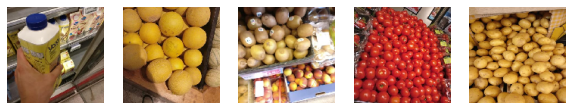

In [8]:
mostrar_imagenes(train_generator)

In [15]:
# Aumento de datos
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

### Entrenamiento del modelo de Machine Learning

In [16]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10

In [17]:
# Modelo CNN básico
def crear_modelo_baseline():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
# Entrenar el modelo CNN básico
modelo_baseline = crear_modelo_baseline()
history_baseline = modelo_baseline.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

Epoch 1/10


c:\users\esteban\appdata\local\programs\python\python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\users\esteban\appdata\local\programs\python\python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 211ms/step - accuracy: 0.0997 - loss: 3.6752 - val_accuracy: 0.0372 - val_loss: 4.4761
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 218ms/step - accuracy: 0.1812 - loss: 3.0787 - val_accuracy: 0.0236 - val_loss: 4.8121
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 211ms/step - accuracy: 0.2804 - loss: 2.6029 - val_accuracy: 0.0946 - val_loss: 5.4469
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 214ms/step - accuracy: 0.3647 - loss: 2.2138 - val_accuracy: 0.0811 - val_loss: 7.3453
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 214ms/step - accuracy: 0.4408 - loss: 1.8308 - val_accuracy: 0.0574 - val_loss: 8.0816
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 0.5079 - loss: 1.6034 - val_accuracy: 0.0811 - val_loss: 8.7800
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step - accuracy: 0.5486 - loss: 1.3914 - val_accuracy: 0.0878 - val_loss: 8.9190
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - accuracy: 0.6111 - loss: 1.2055 - val_accuracy: 0.077

In [19]:
# Modelo de Transfer Learning con MobileNetV2
def crear_modelo_transfer():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    base_model.trainable = False  # Congelar las capas de MobileNetV2
    
    model = Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [20]:
# Entrenar el modelo de Transfer Learning
modelo_transfer = crear_modelo_transfer()
history_transfer = modelo_transfer.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - accuracy: 0.2188 - loss: 3.2498 - val_accuracy: 0.0878 - val_loss: 5.2751
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - accuracy: 0.5883 - loss: 1.4385 - val_accuracy: 0.0878 - val_loss: 6.3177
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.7530 - loss: 0.8228 - val_accuracy: 0.1081 - val_loss: 7.2508
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 0.8152 - loss: 0.5839 - val_accuracy: 0.1182 - val_loss: 8.1592
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.8788 - loss: 0.4278 - val_accuracy: 0.1149 - val_loss: 8.4914
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.8939 - loss: 0.3488 - val_accuracy: 0.1182 - val_loss: 8.8780
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.9265 - loss: 0.2824 - val_accuracy: 0.1081 - val_loss: 9.4647
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 0.9397 - loss: 0.2255 - val_accu

### Evaluación de los modelos

In [21]:
print("Evaluación del modelo CNN básico:")
baseline_eval = modelo_baseline.evaluate(test_generator)

print("\nEvaluación del modelo Transfer Learning:")
transfer_eval = modelo_transfer.evaluate(test_generator)

Evaluación del modelo CNN básico:
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.1598 - loss: 10.9787

Evaluación del modelo Transfer Learning:
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.2149 - loss: 9.1737


In [22]:
modelo_transfer.save('modelo_clasificacion_imagenes.keras')

In [23]:
modelo_transfer_cargado = tf.keras.models.load_model('modelo_clasificacion_imagenes.keras')

In [ ]:
ruta_imagen = r'C:\Users\Esteban\Documents\MINE\GroceryStoreDataset\dataset\test\Fruit\Plum\Plum_014.jpg'
image = tf.keras.preprocessing.image.load_img(ruta_imagen,target_size=(64,64))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = modelo_transfer_cargado.predict(input_arr)
result_index = np.argmax(predictions) #Return index of max element
print(result_index)

In [ ]:
# ruta_imagen = r'C:\Users\Esteban\Documents\MINE\GroceryStoreDataset\dataset\test\Fruit\Plum\Plum_014.jpg'
# print(ruta_imagen)
# # Preprocesar la imagen
# img_preprocesada = preprocesar_imagen(ruta_imagen)
# print(img_preprocesada.shape)
# # Hacer la predicción
# prediccion = modelo_transfer_cargado.predict(img_preprocesada)
# 
# # Obtener el índice de la clase con mayor probabilidad
# clase_predicha = np.argmax(prediccion, axis=1)[0]
# print(np.argmax(prediccion, axis=1))
# print(f"Clase predicha: {clase_predicha}")
# 
# print(test_generator.class_names[clase_predicha])

In [24]:
# Obtener las etiquetas de las clases
class_labels = list(test_generator.class_indices.keys())
print(class_labels)
# Función para realizar predicciones y generar etiquetas
def obtener_predicciones(model, generator):
    # Generar predicciones en el conjunto de prueba
    generator.reset()
    predictions = model.predict(generator, verbose=1)
    # Obtener índices de las clases predichas
    pred_indices = np.argmax(predictions, axis=1)
    # Obtener etiquetas reales e índices de clases reales
    true_indices = generator.classes
    true_labels = [class_labels[i] for i in true_indices]
    pred_labels = [class_labels[i] for i in pred_indices]
    return true_labels, pred_labels
 
# Validación del modelo CNN básico
print("Resultados del modelo CNN básico:")
true_labels_baseline, pred_labels_baseline = obtener_predicciones(modelo_baseline, test_generator)
print(classification_report(true_labels_baseline, pred_labels_baseline))
print(confusion_matrix(true_labels_baseline, pred_labels_baseline))
 
# Validación del modelo de Transfer Learning
print("\nResultados del modelo de Transfer Learning:")
true_labels_transfer, pred_labels_transfer = obtener_predicciones(modelo_transfer, test_generator)
print(classification_report(true_labels_transfer, pred_labels_transfer))
print(confusion_matrix(true_labels_transfer, pred_labels_transfer))
 
# Guardar etiquetas en un DataFrame
df_baseline = pd.DataFrame({
    'True Label': true_labels_baseline,
    'Predicted Label (CNN)': pred_labels_baseline
})
 
df_transfer = pd.DataFrame({
    'True Label': true_labels_transfer,
    'Predicted Label (Transfer Learning)': pred_labels_transfer
})
 
# Mostrar las primeras filas de las predicciones
print("\nPredicciones del modelo CNN básico:\n", df_baseline.head())
print("\nPredicciones del modelo de Transfer Learning:\n", df_transfer.head())

['Apple', 'Asparagus', 'Aubergine', 'Avocado', 'Banana', 'Cabbage', 'Carrots', 'Cucumber', 'Fruit', 'Garlic', 'Ginger', 'Juice', 'Kiwi', 'Leek', 'Lemon', 'Lime', 'Mango', 'Melon', 'Milk', 'Mushroom', 'Nectarine', 'New folder', 'New folder - Copy', 'New folder - Copy (2)', 'New folder - Copy (3)', 'Oat-Milk', 'Oatghurt', 'Onion', 'Orange', 'Packages', 'Papaya', 'Passion-Fruit', 'Peach', 'Pear', 'Pepper', 'Pineapple', 'Plum', 'Pomegranate', 'Potato', 'Red-Beet', 'Red-Grapefruit', 'Satsumas', 'Sour-Cream', 'Sour-Milk', 'Soy-Milk', 'Soyghurt', 'Tomato', 'Vegetables', 'Yoghurt', 'Zucchini']
Resultados del modelo CNN básico:
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step
                       precision    recall  f1-score   support

                Apple       0.00      0.00      0.00       276
            Asparagus       0.00      0.00      0.00        14
            Aubergine       0.00      0.00      0.00        22
              Avocado       0.05      0.03      0.03        40
               Ba

c:\users\esteban\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\esteban\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\esteban\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step
                       precision    recall  f1-score   support

                Apple       0.06      0.00      0.01       276
            Asparagus       0.00      0.00      0.00        14
            Aubergine       0.03      0.05      0.03        22
              Avocado       0.02      0.03      0.02        40
               Banana       0.00      0.00      0.00        44
              Cabbage       0.00      0.00      0.00        19
              Carrots       0.00      0.00      0.00        42
             Cucumber       0.00      0.00      0.00        27
               Garlic       0.00      0.00      0.00        25
               Ginger       0.00      0.00      0.00        15
                Juice       0.05      0.01      0.02       219
                 Kiwi       0.02      0.02      0.02        45
                 Leek       0.01      0.14      0.02        21
                Lemon       0.02      0.02      0.02        41
            

c:\users\esteban\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\esteban\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\esteban\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

In [ ]:
class_labels = list(test_generator.class_indices.values())
print(class_labels)